In [1]:
!pip3 install transformers
!pip3 install datasets

In [2]:
binary = False

# Preparando Dataset

In [3]:
from datasets import Dataset
import pandas as pd

In [4]:
data_df = pd.read_csv("/content/drive/MyDrive/Mestrado/transformers/data/tweetsentbr_train.csv", index_col=0)

In [5]:
if binary:
  data_df = data_df[data_df["label"] != 0]
  data_df["label"] -= 1 # 0 será a classe positiva, 1 será a classe negativa

In [7]:
ds = Dataset.from_pandas(data_df)

In [8]:
ds

Dataset({
    features: ['label', 'text', '__index_level_0__'],
    num_rows: 9849
})

# Carregando modelos

In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch.nn as nn

In [10]:
model = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizerFast.from_pretrained(model)
model = BertForSequenceClassification.from_pretrained(model, num_labels=2 if binary else 3)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [11]:
model.config

BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 2979

In [12]:
# Atualizando a camada de classificador final. É preciso ajustar os parametros para o Trainer funcionar
# NÃO é preciso definir tudo isto caso seja especificado o num_labels no método from_pretrained
# model.classifier = nn.Linear(in_features=model.config.hidden_size, out_features=n_classes)
# model.num_labels = n_classes

In [13]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Analisando número de tokens no conjunto de dados inteiro

In [14]:
def get_num_tokens(text: str) -> int:
  return len(tokenizer.encode(text))

In [15]:
data_df["num_tokens"] = data_df["text"].apply(get_num_tokens)

In [16]:
data_df.head()

,label,text,num_tokens
5689,1,Simplesmente magnífica @fbbreal no Video Show ...,33
5386,1,"Saiu, mas saiu ahazando. Master Chef BR",16
869,1,Já tô pronta pro Master Chef BR,11
5432,1,Muito amor por é o tchan Altas Horas,12
24,1,QUE PROGRAMA INCRÍVEL O @SBTTheNoite FEZ HOJE!...,60


In [17]:
data_df["num_tokens"].describe()

count    9849.000000
mean       23.718652
std         9.820523
min         6.000000
25%        16.000000
50%        22.000000
75%        30.000000
max        95.000000
Name: num_tokens, dtype: float64

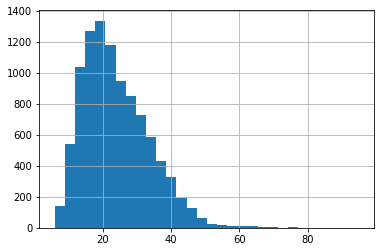

In [18]:
data_df["num_tokens"].hist(bins=30)

# Pre-processamento de Datasets

In [19]:
from transformers import DataCollatorWithPadding

In [20]:
def tokenizer_function(example):
  # Em caso de uma tarefa de classificação de pares de texto, modificar este valor de retorno
  # truncation=True, padding="max_length", max_length=123 para truncar e padronizar os tamanhos de tokens!!!
  return tokenizer(
      example["text"], truncation=True
  )

In [21]:
# Tokenizando todos os elementos do conjunto de dados em batches
ds = ds.map(tokenizer_function, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [22]:
# Mantendo apenas colunas cujos nomes coincidam com os métodos forward dos transformers
ds = ds.remove_columns(column_names=["text", "__index_level_0__"])
ds = ds.rename_column("label", "labels")
ds = ds.with_format("torch")

In [23]:
# Split de treino e teste (20%)
ds = ds.train_test_split(0.1)

In [24]:
ds

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 8864
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 985
    })
})

In [25]:
# Collator para Dynamic Padding
collator = DataCollatorWithPadding(tokenizer, padding="longest")

# Configurando Trainer

In [26]:
from transformers import Trainer, TrainingArguments, get_cosine_schedule_with_warmup, AdamW
from datasets import load_metric
import math

In [27]:
bs = 64
epochs = 5
lr = 2e-5
warmup_steps = math.ceil((len(ds["train"])/bs) * epochs * 0.1) #10% of train data for warm-up
train_steps = int(epochs * len(ds["train"])/bs)

In [28]:
warmup_steps, train_steps

(70, 692)

In [29]:
import numpy as np
from sklearn.metrics import classification_report
from datasets import load_metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metrics_dict = classification_report(labels, predictions, output_dict=True)

    return {
        "accuracy": metrics_dict["accuracy"],
        "precision": metrics_dict["macro avg"]["precision"],
        "recall": metrics_dict["macro avg"]["recall"],
        "f1": metrics_dict["macro avg"]["f1-score"]
    }


In [30]:
optimizer = AdamW(model.parameters(), lr=lr) 
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=train_steps, num_cycles=0.5)

In [31]:
output_dir = '/content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/binary' if binary else \
             '/content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes'

In [32]:
output_dir

'/content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes'

In [33]:
training_args = TrainingArguments(
    output_dir=output_dir,                                                                                # output directory
    num_train_epochs=epochs,                                                                              # total number of training epochs
    per_device_train_batch_size=bs,                                                                       # batch size per device during training
    per_device_eval_batch_size=bs,                                                                        # batch size for evaluation
    # warmup_steps=warmup_steps,                                                                            # number of warmup steps for learning rate scheduler
    weight_decay=0.001,                                                                                   # strength of weight decay
    evaluation_strategy="epoch",                                                                          # evaluation interval
    logging_dir='./logs',                                                                                 # directory for storing logs
    save_strategy="epoch",                                                                                # checkpoint save interval
    logging_steps=200,
)


In [34]:
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
    data_collator=collator
)

In [35]:
trainer.train()

***** Running training *****
  Num examples = 8864
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 695


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.696094,0.706599,0.690701,0.693036,0.684777
2,0.829000,0.656066,0.728934,0.712552,0.712865,0.711868
3,0.556600,0.673312,0.729949,0.715815,0.705864,0.708868
4,0.556600,0.720580,0.727919,0.712686,0.708991,0.710548
5,0.403600,0.739228,0.725888,0.711149,0.703187,0.705886


***** Running Evaluation *****
  Num examples = 985
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes/checkpoint-139
Configuration saved in /content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes/checkpoint-139/config.json
Model weights saved in /content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes/checkpoint-139/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 985
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes/checkpoint-278
Configuration saved in /content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes/checkpoint-278/config.json
Model weights saved in /content/drive/MyDrive/Mestrado/transformers/trained_models/bertimbau_tweetsentbr/all_classes/checkpoint-278/pytorch_model.bin


TrainOutput(global_step=695, training_loss=0.5657369984139642, metrics={'train_runtime': 806.3246, 'train_samples_per_second': 54.965, 'train_steps_per_second': 0.862, 'total_flos': 1204582560124608.0, 'train_loss': 0.5657369984139642, 'epoch': 5.0})